# GeoPython 2022 - Introduction to `dask-geopandas`

## Setup

```
- geopandas
- dask-geopandas
- pyogrio
- pyarrow
- python-graphviz
- esda
- extension??
```

## GeoPandas refresh
- Extending pandas with geometry support
- One or more geometry columns

In [1]:
import geopandas

In [2]:
path = geopandas.datasets.get_path("naturalearth_lowres")
path

'/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp'

In [3]:
world = geopandas.read_file(path)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [4]:
world = world.query("continent != 'Antarctica'").to_crs(3857)

In [5]:
world['convex_hull'] = world.convex_hull

# This is equal to the code above as GeoPandas exposes geometry methods of the active geometry column to the GeoDataFrame level
# world['convex_hull'] = world.geometry.convex_hull  

In [6]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((20037508.343 -1812498.413, 200...","POLYGON ((19807373.107 -2071284.965, -20037508..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((3774143.866 -105758.362, 3792946.708...","POLYGON ((4064728.977 -1313965.660, 3847200.38..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-964649.018 3205725.605, -964597.245...","POLYGON ((-1899491.585 2391849.029, -1894705.4..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-9205018.632 5112435.324, -13805051...."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-17331127.807 2145071.126, -17358788..."


<AxesSubplot:>

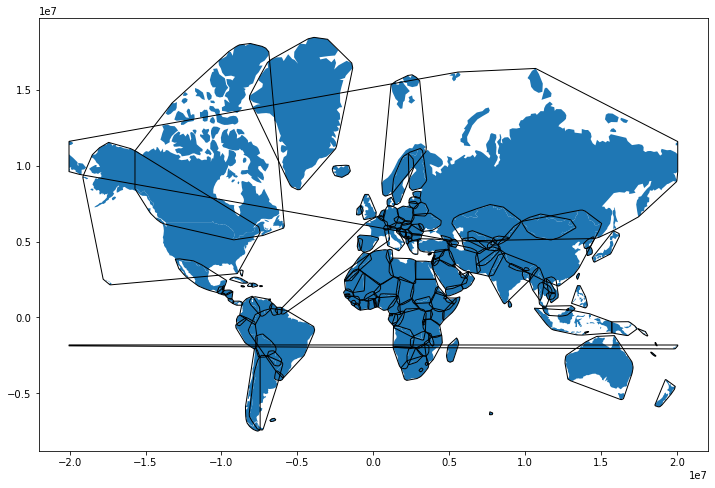

In [7]:
ax = world.plot(figsize=(12, 12))
world.convex_hull.plot(ax=ax, facecolor='none', edgecolor='black')

## What is Dask
- parallel and distributed computation
- low-level
- high-level
    - array, bag, dataframe
- client, cluster

In [8]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [9]:
from dask.distributed import Client

client = Client(n_workers=4)

2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/martin/Git/dask-geopandas-tutorial/dask-worker-space/worker-yjfhid4n', purging
2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/martin/Git/dask-geopandas-tutorial/dask-worker-space/worker-jom_dvrl', purging
2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/martin/Git/dask-geopandas-tutorial/dask-worker-space/worker-h4qx7qlv', purging
2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/martin/Git/dask-geopandas-tutorial/dask-worker-space/worker-itp_fp4k', purging
2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/martin/Git/dask-geopandas-tutorial/dask-worker-space/worker-73tldi8f', purging
2022-06-21 14:59:59,597 - distributed.diskutils - INFO - Found stale lock file and directory '/Users

### dask.bag

In [10]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>

In [11]:
b.sum()

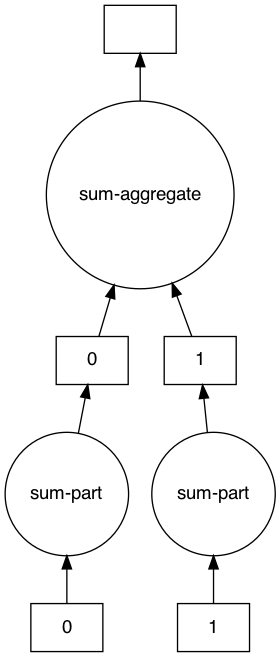

In [12]:
b.sum().visualize()

In [13]:
b.sum().compute()

24

### dask.array

In [14]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [15]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

In [16]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [17]:
a.mean().compute()

49999.5

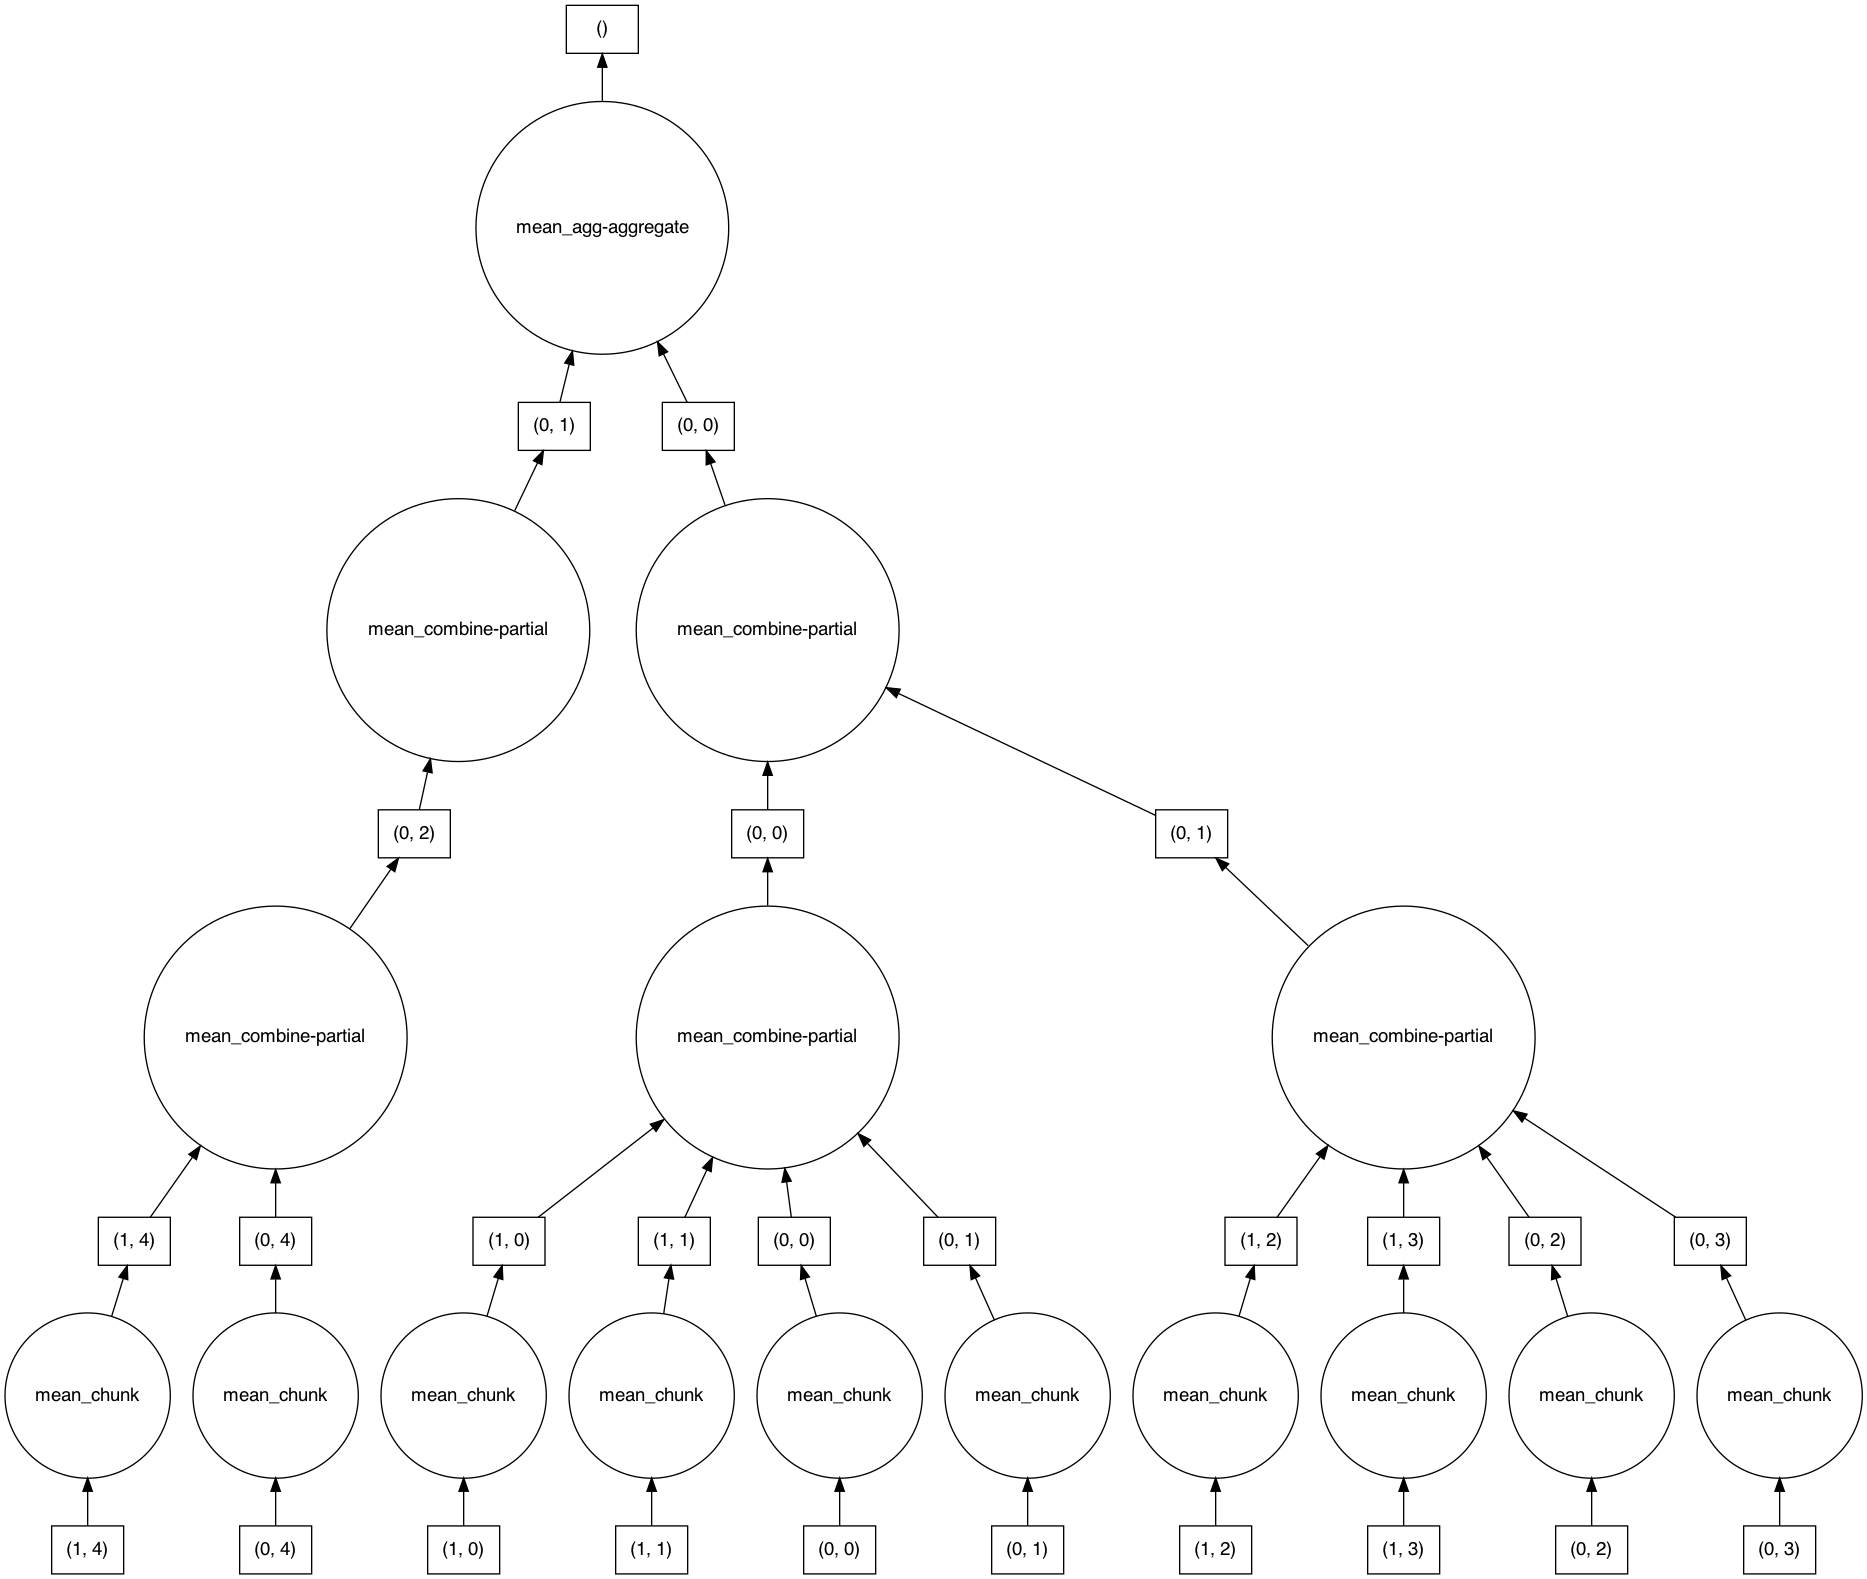

In [18]:
a.mean().visualize()

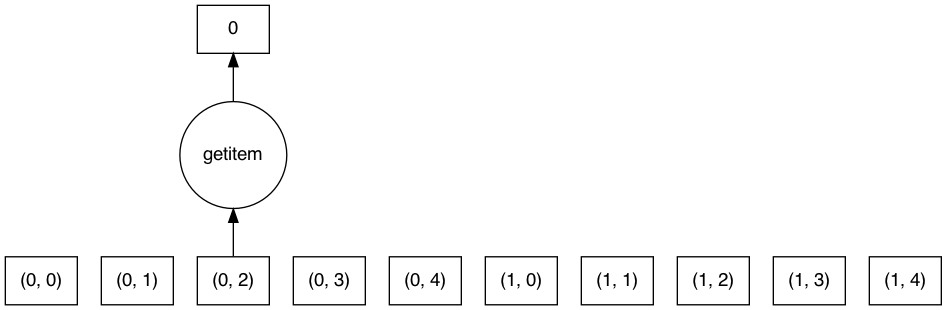

In [19]:
a[:50, 200].visualize()

### dask.dataframe
- many pandas DataFrames as _partitions_
- concept of delayed computation
    - task graph
    - show some mean, groupby
- inter-worker communication

In [20]:
df = pd.read_csv("data/airports.csv")
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


In [21]:
import dask.dataframe as dd

df = dd.read_csv("data/airports.csv")
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


In [22]:
df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
npartitions=1,,,,,,,
,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...


In [23]:
df = dd.read_csv("data/airports_csv/*.csv")
df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
npartitions=4,,,,,,,
,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [24]:
elevation = df.elevation_ft.mean()
elevation

dd.Scalar<series-..., dtype=float64>

In [25]:
elevation.compute()

1294.776494472499

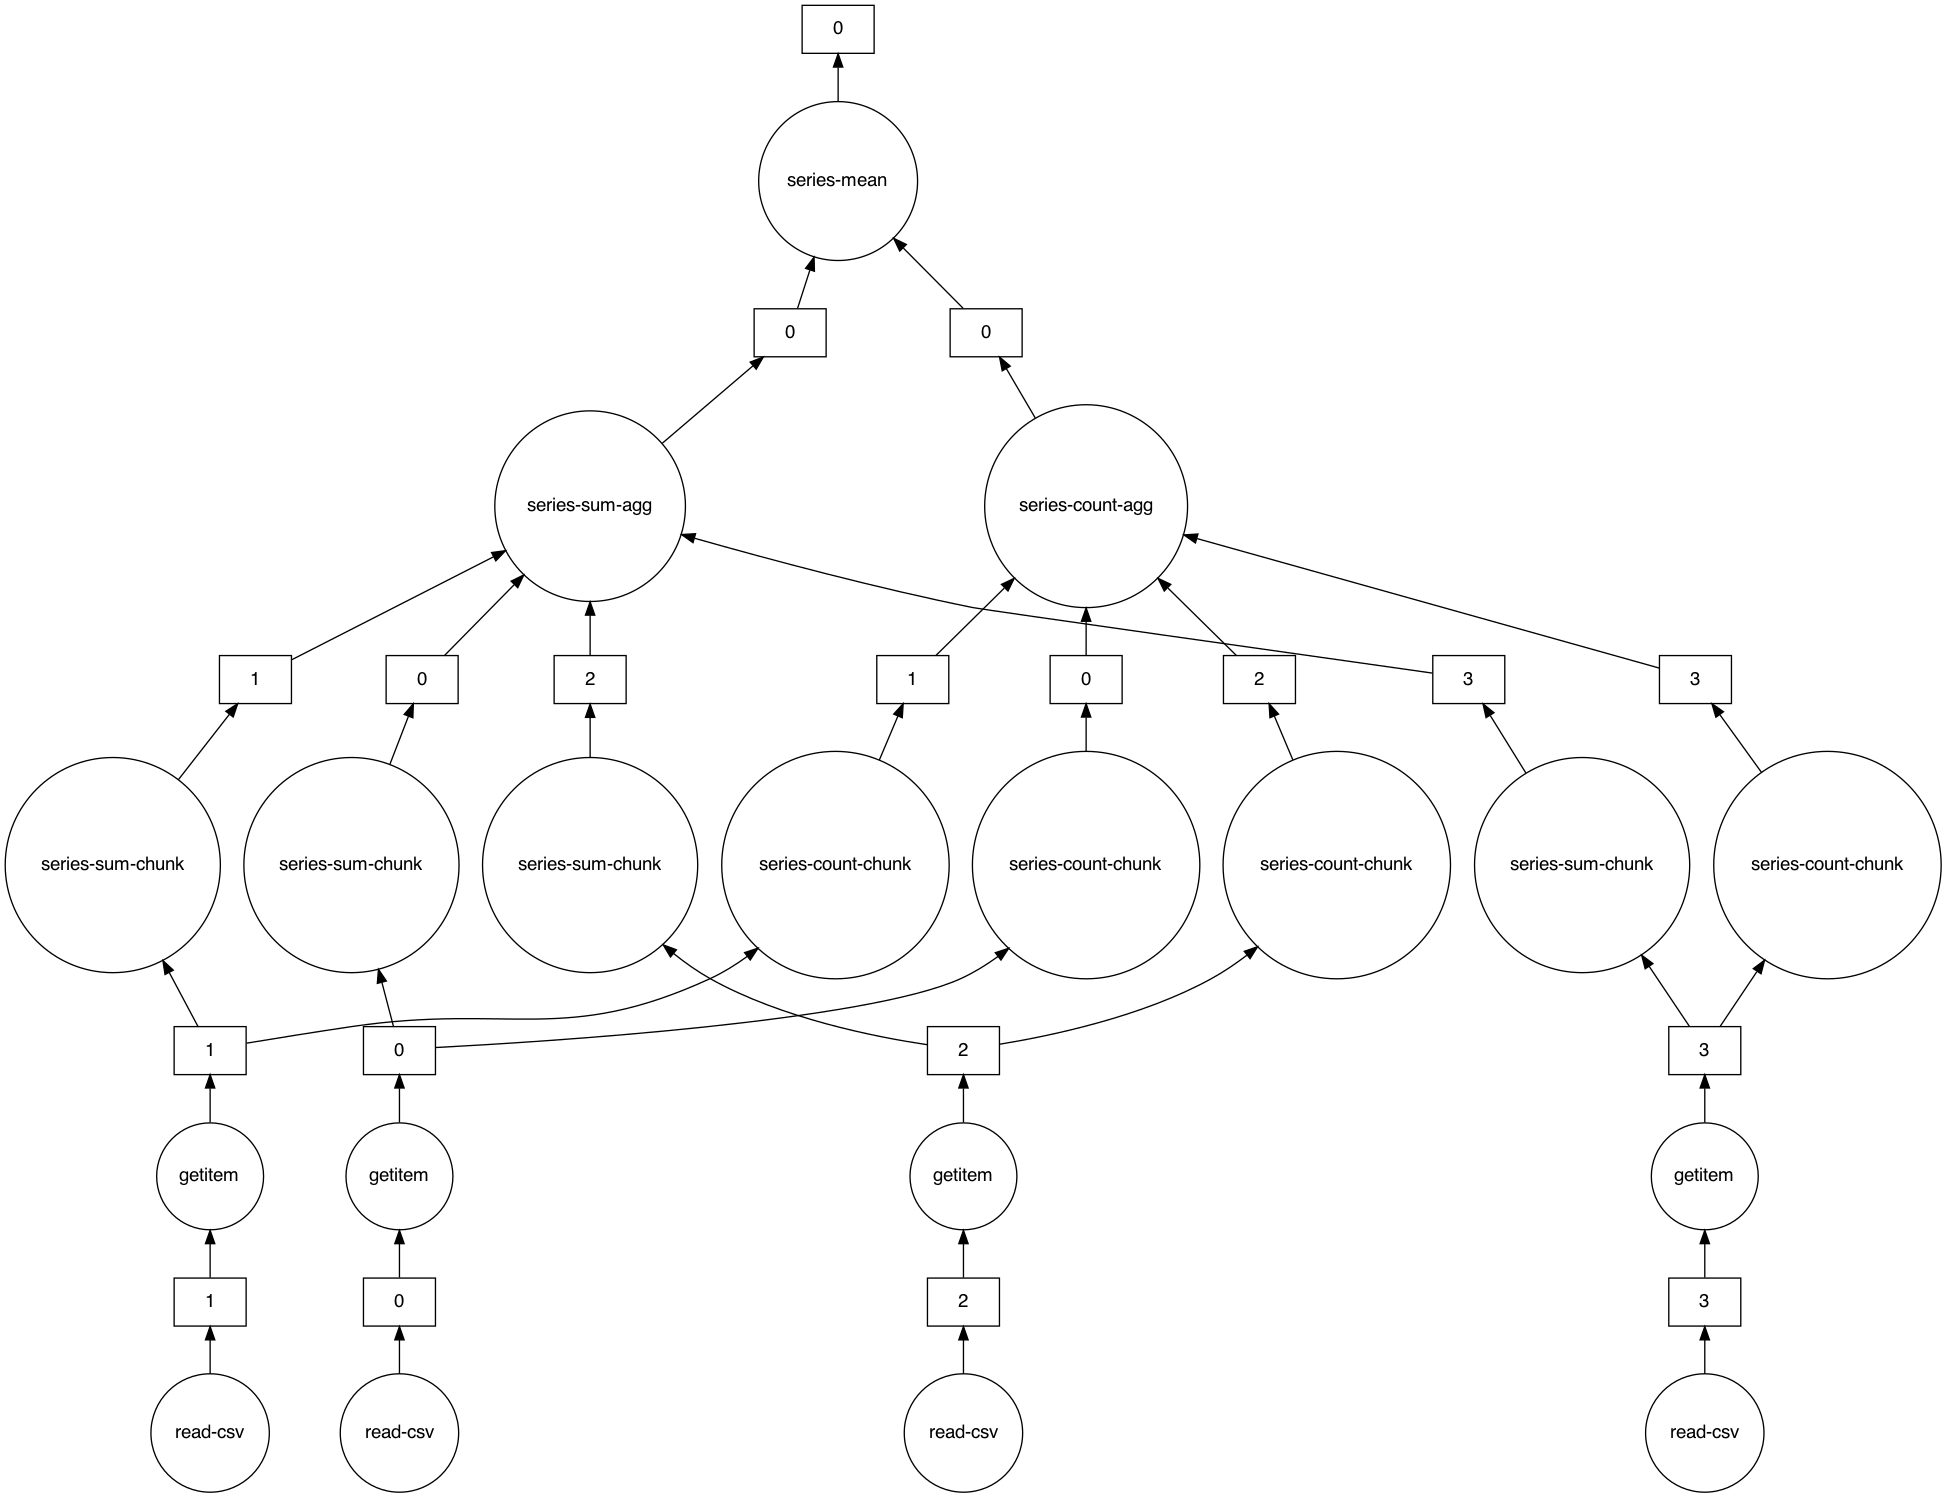

In [26]:
elevation.visualize()

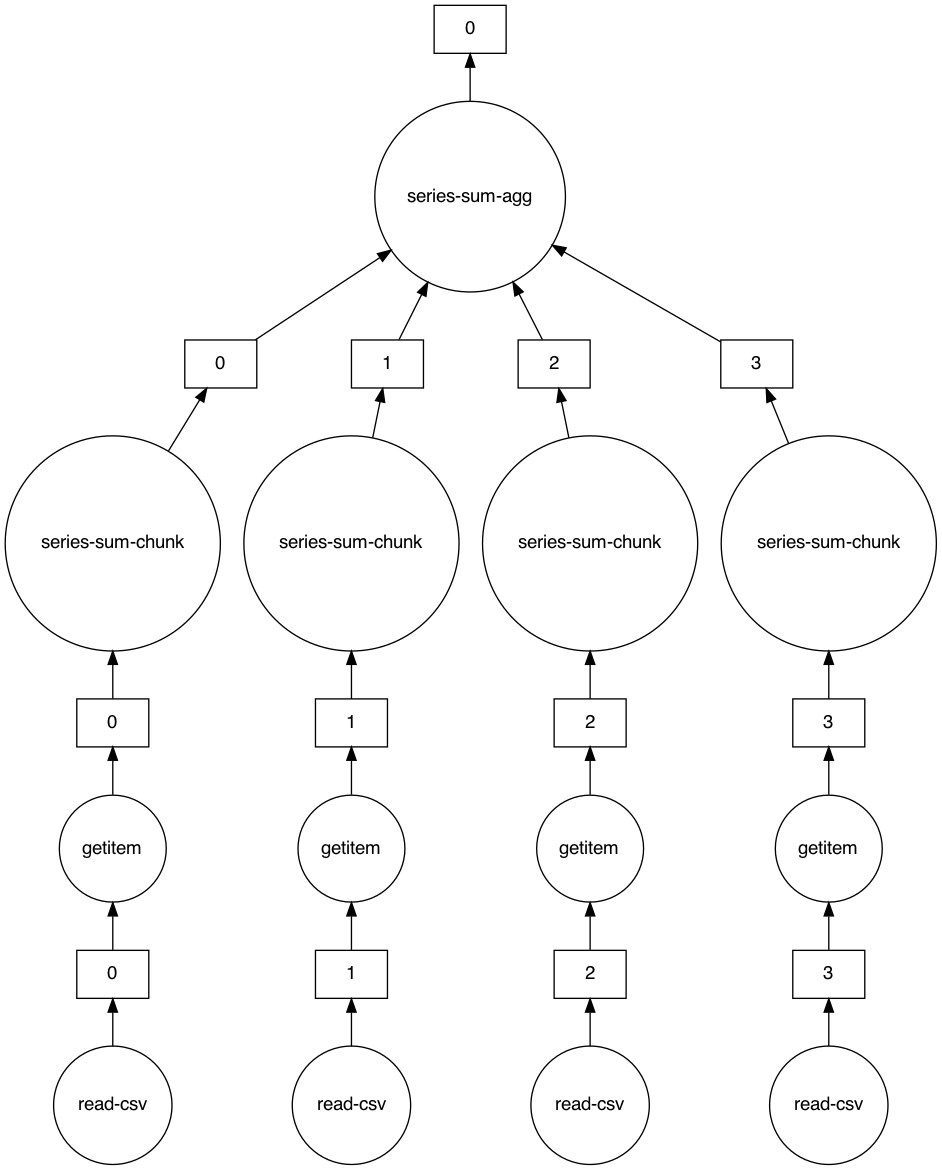

In [27]:
df.elevation_ft.sum().visualize()

In [28]:
df.elevation_ft.sum().compute()

75894619.0

## Dask-GeoPandas 
- follows the same model. But *spatial is special*.
- many geopandas GeoDataFrames as _partitions_

In [29]:
import dask_geopandas

## Create dask GeoDataFrame
- from geopandas
    - npartitions
- read_file with pyogrio
- read GeoParquet
- from dask.dataframe with XY or WKT

In [30]:
world_ddf = dask_geopandas.from_geopandas(world, npartitions=4)
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
0,int64,object,object,object,float64,geometry,geometry
44,...,...,...,...,...,...,...
88,...,...,...,...,...,...,...
132,...,...,...,...,...,...,...
176,...,...,...,...,...,...,...


In [31]:
world_ddf_file = dask_geopandas.read_file(path, npartitions=4)
world_ddf_file

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
0,int64,object,object,object,float64,geometry
45,...,...,...,...,...,...
90,...,...,...,...,...,...
135,...,...,...,...,...,...
176,...,...,...,...,...,...


### Partitioned IO
- GeoParquet

In [32]:
world_ddf.to_parquet("world/")

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  return self.engine.write_partition(
/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github

In [33]:
world_ddf = dask_geopandas.read_parquet("world/")
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
,int64,object,object,object,float64,geometry,geometry
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


## Embarrassingly parallel computation
- area
- convex_hull

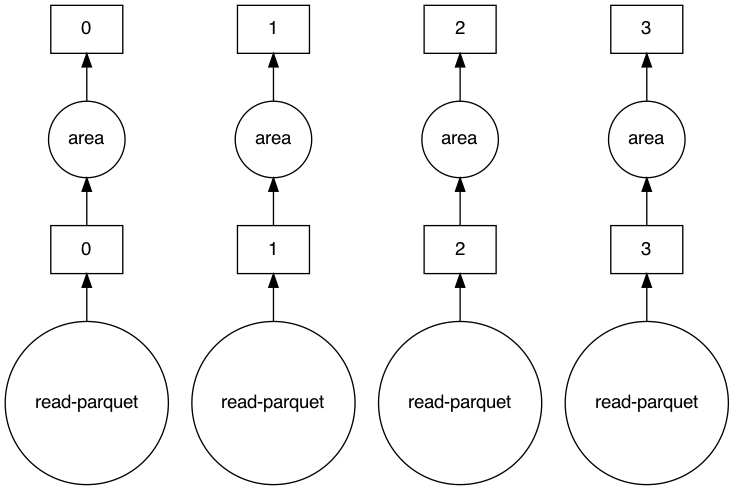

In [34]:
area = world_ddf.area
area.visualize()

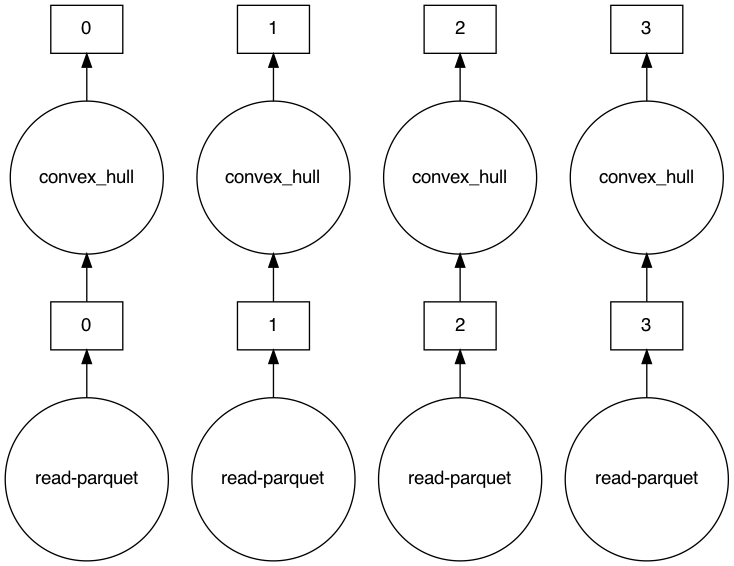

In [35]:
convex_hull = world_ddf.convex_hull
convex_hull.visualize()

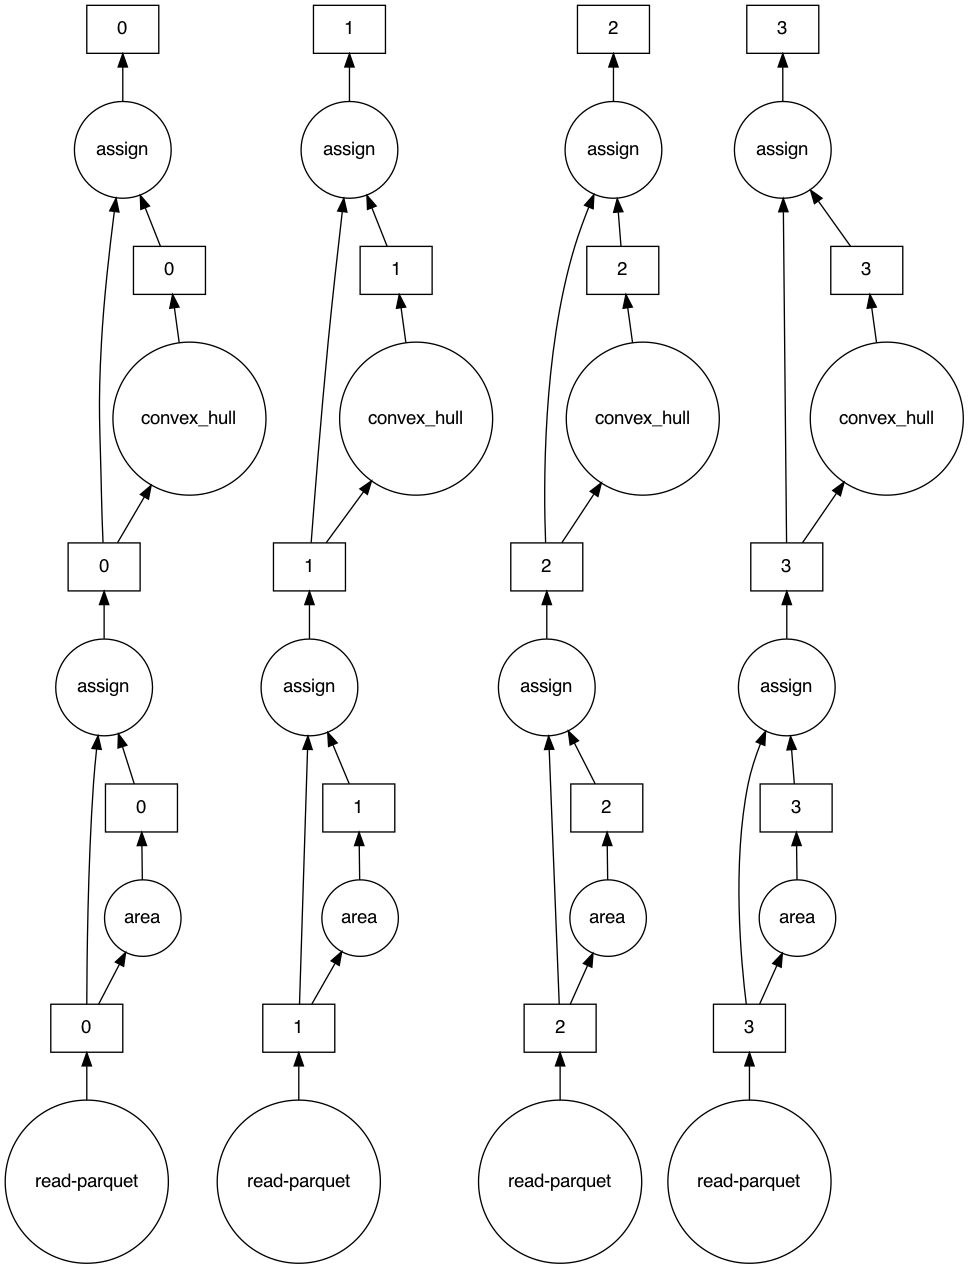

In [36]:
world_ddf['area'] = world_ddf.area
world_ddf['convex_hull'] = world_ddf.convex_hull
world_ddf.visualize()

In [37]:
r = world_ddf.compute()

## Spatial join
- include comparison of default and spatially shuffled df
- GADM join with airports?

In [38]:
airports = pd.read_csv("data/airports.csv")
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


In [39]:
airports = geopandas.GeoDataFrame(
    airports,
    geometry=geopandas.GeoSeries.from_xy(
        airports["longitude_deg"],
        airports["latitude_deg"],
        crs=4326,
    )
)

airports_ddf = dask_geopandas.from_geopandas(
    airports,
    npartitions=12
)

In [40]:
world_ddf = dask_geopandas.read_parquet("data/world/")

joined = airports_ddf.sjoin(world_ddf, predicate="within")

In [41]:
joined.npartitions

48

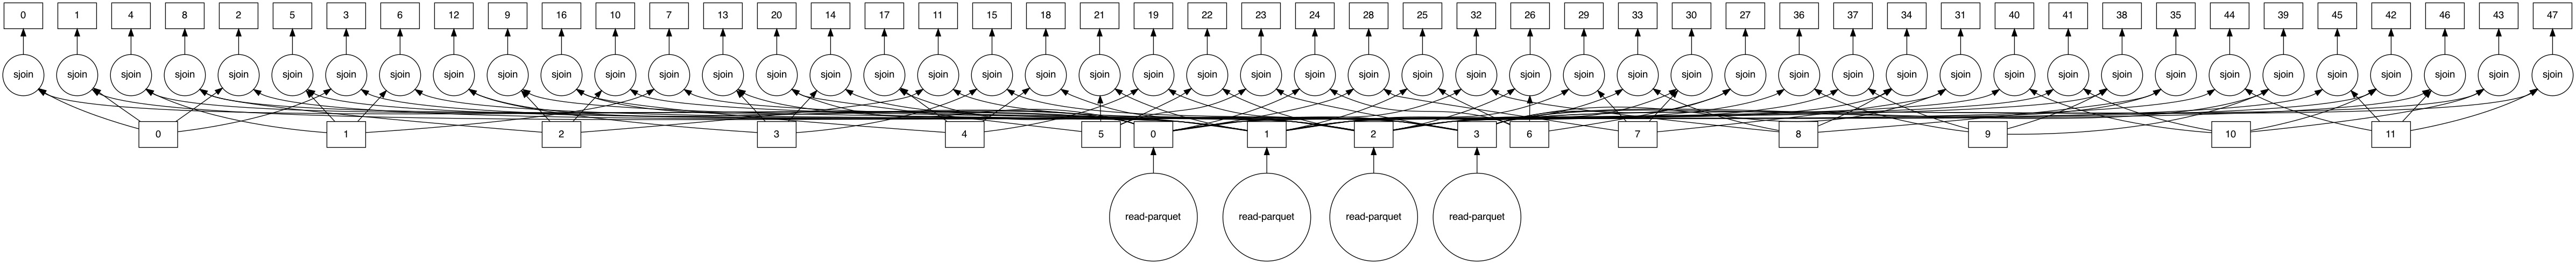

In [42]:
joined.visualize()

## Spatial partitioning
- default
- spatial shuffle
    - explain space filling curve

In [43]:
airports_ddf.calculate_spatial_partitions()

In [44]:
airports_ddf.spatial_partitions

0     POLYGON ((169.85200 11.22200, -155.97835 19.83...
1     POLYGON ((-1.00000 -89.98944, -41.03330 -77.65...
2     POLYGON ((106.84825 -78.46614, -67.75550 -54.6...
3     POLYGON ((-25.51644 -75.56741, -71.56667 -74.8...
4     POLYGON ((-36.50950 -54.28240, -155.57840 19.1...
5     POLYGON ((139.27850 -24.33880, -157.19466 1.76...
6     POLYGON ((146.39617 -41.23519, -70.64390 -38.0...
7     POLYGON ((0.00000 -90.00000, -176.20348 -44.29...
8     POLYGON ((-81.39478 -80.31420, -83.32083 -79.7...
9     POLYGON ((70.22033 -49.35033, -56.16673 -34.86...
10    POLYGON ((-155.67730 18.91630, -159.74431 21.9...
11    POLYGON ((111.52361 -66.69083, -171.43511 -14....
dtype: geometry

In [45]:
airports_ddf.spatial_partitions.explore()

In [46]:
airports_ddf = airports_ddf.spatial_shuffle()

In [47]:
airports_ddf.spatial_partitions.explore()

In [48]:
world_ddf.spatial_partitions is not None

True

In [49]:
world_ddf.spatial_partitions.explore()

In [50]:
joined = airports_ddf.sjoin(world_ddf, predicate="within")

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_97216/1671005557.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(world_ddf, predicate="within")


In [51]:
joined.npartitions

33

In [52]:
%%time
joined.compute()

CPU times: user 216 ms, sys: 56.5 ms, total: 272 ms
Wall time: 508 ms


,id,ident,type,name_left,latitude_deg,longitude_deg,elevation_ft,geometry,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est,convex_hull
hilbert_distance,,,,,,,,,,,,,,,
801122366,41113,SE16,small_airport,Loja Airport,-3.881424,-79.234749,7684.0,POINT (-79.23475 -3.88142),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
801144915,6083,SETM,small_airport,Camilo Ponce Enriquez Airport,-3.995890,-79.371902,4056.0,POINT (-79.37190 -3.99589),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
801352465,41595,EC-0001,small_airport,Carabon Airport,-3.628550,-80.187798,126.0,POINT (-80.18780 -3.62855),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
1880303520,2066,DAOE,small_airport,Bou Sfer Airport,35.735401,-0.805389,187.0,POINT (-0.80539 35.73540),82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((351561.777 2161690.786, -966742.962 ..."
1880352370,2071,DAOO,medium_airport,Oran International Airport Ahmed Ben Bella,35.623901,-0.621183,295.0,POINT (-0.62118 35.62390),82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((351561.777 2161690.786, -966742.962 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278400869,342012,VU-0002,closed,Luganville Airfield,-15.515500,167.131900,484.0,POINT (167.13190 -15.51550),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."
3278411657,342011,VU-0001,closed,Turtle Bay Airfield,-15.377557,167.179473,58.0,POINT (167.17947 -15.37756),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."
3278684342,32056,NVSP,small_airport,Norsup Airport,-16.079700,167.401001,23.0,POINT (167.40100 -16.07970),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."


In [53]:
import pyogrio

gadm = pyogrio.read_dataframe('data/gadm404.gpkg')

In [54]:
gadm_ddf = dask_geopandas.from_geopandas(gadm, npartitions=64)
joined = airports_ddf.sjoin(gadm_ddf, predicate="within")
joined.npartitions

768

In [55]:
gadm_sorted = dask_geopandas.read_parquet("data/gadm_spatial/")
joined = airports_ddf.sjoin(gadm_sorted, predicate="within")
joined.npartitions

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_97216/1806312542.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(gadm_sorted, predicate="within")


158

## Aggregations with dissolve

In [56]:
world_ddf = dask_geopandas.read_parquet("data/world/")  # TODO get better world with more polygons
continents = world_ddf.dissolve('continent', split_out=6)
continents

,pop_est,name,iso_a3,gdp_md_est,convex_hull,geometry
npartitions=6,,,,,,
,int64,object,object,float64,geometry,geometry
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


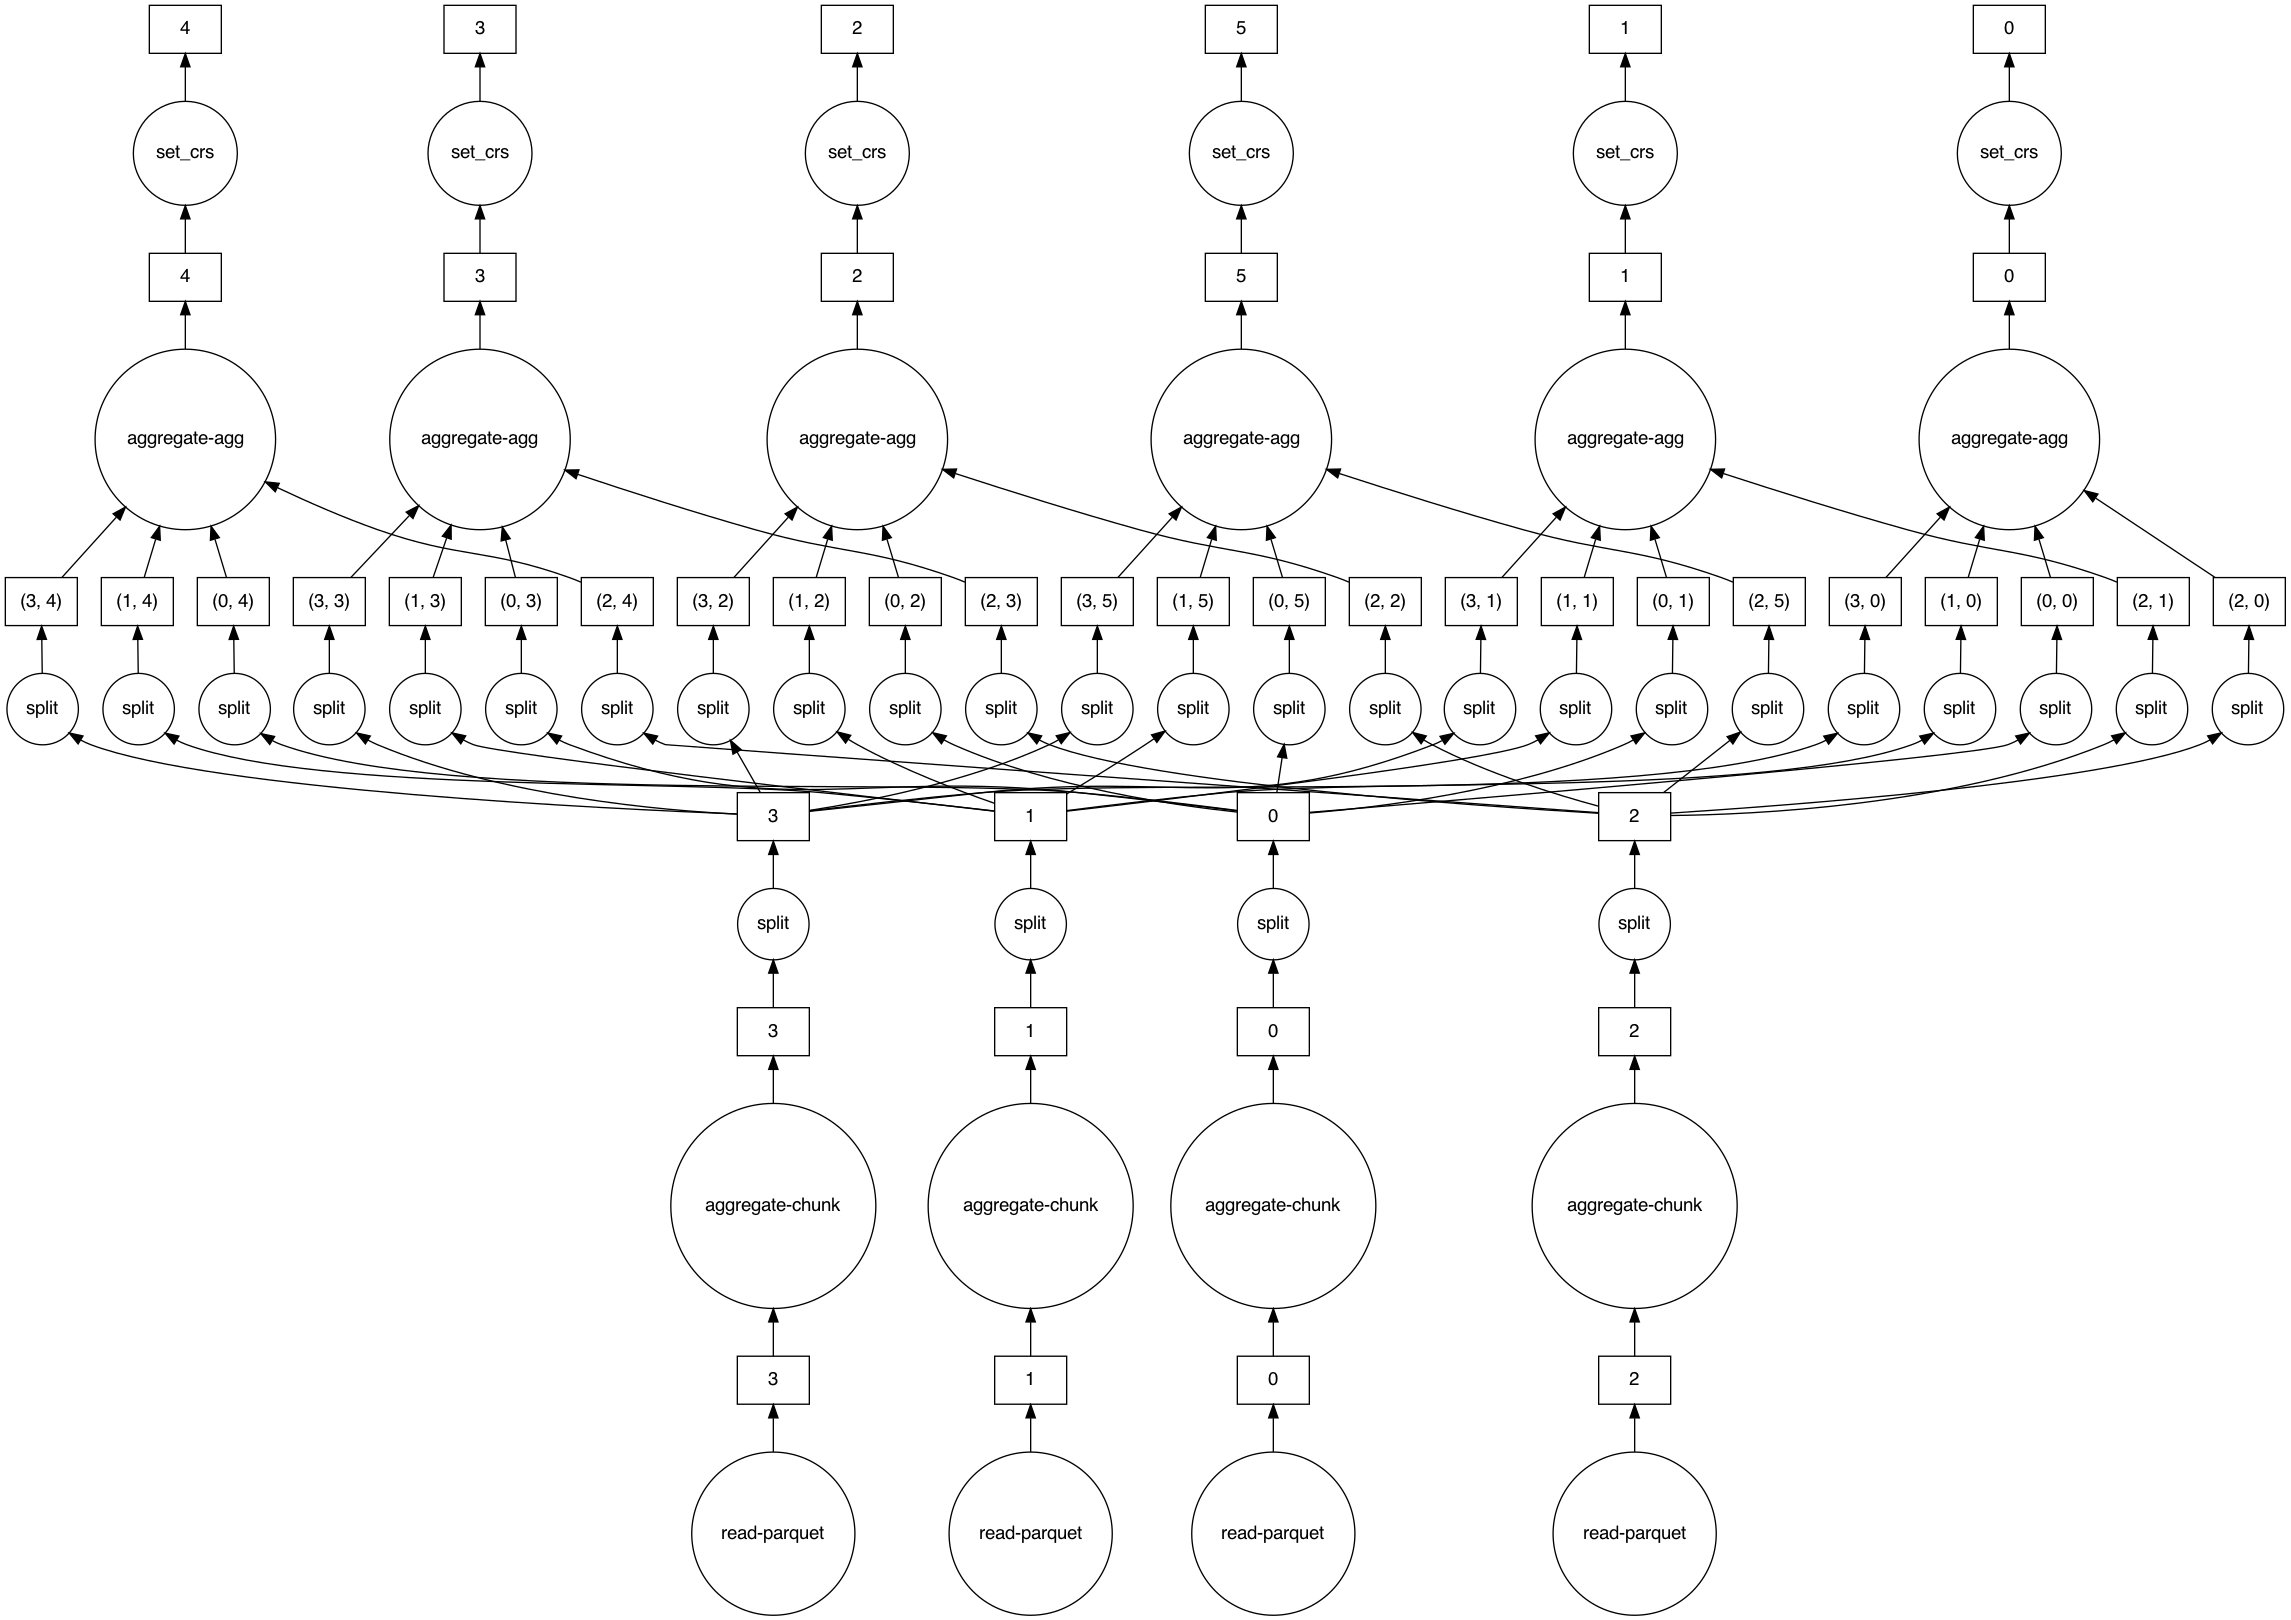

In [57]:
continents.visualize()

## Custom functions

In [58]:
from esda.shape import shape_index

In [59]:
world['shape_idx'] = shape_index(world)

In [60]:
world.explore('shape_idx')

In [61]:
world_ddf = dask_geopandas.read_parquet("world/")
shape_idx = world_ddf.map_partitions(shape_index)

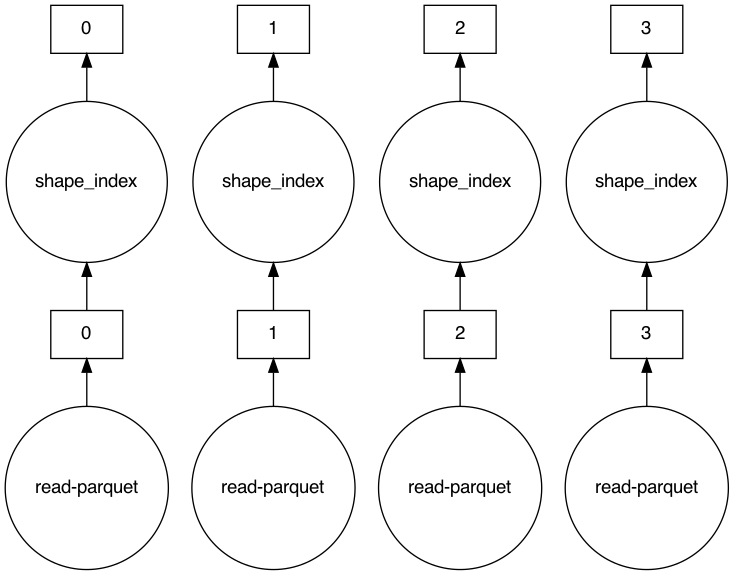

In [62]:
shape_idx.visualize()

In [63]:
r = shape_idx.compute()

### Custom function

In [64]:
def my_fn(gdf):
    """get a sum of area covered by polygons in a gdf
    
    Parameters
    ----------
    gdf : GeoDataFrame
    
    Returns
    -------
    float
    
    """
    area = gdf.geometry.area
    return sum(area)

In [65]:
world_ddf.map_partitions(my_fn).compute()

0    2.404711e+14
1    1.883620e+13
2    2.622637e+13
3    4.235641e+13
dtype: float64

In [66]:
def get_hull_area(gdf):
    """Get area of each convex hull and return pandas.Series
    
    Parameters
    ----------
    gdf : GeoDataFrame
    
    Returns
    -------
    pandas.Series
    """
    
    hulls = gdf.convex_hull
    return hulls.area

In [67]:
world_ddf['hull_area'] = world_ddf.map_partitions(get_hull_area)

In [68]:
world_ddf.compute()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull,hull_area
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((20037508.343 -1812498.413, 200...","POLYGON ((19807373.107 -2071284.965, -20037508...",6.432272e+12
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((3774143.866 -105758.362, 3792946.708...","POLYGON ((4064728.977 -1313965.660, 3847200.38...",1.059699e+12
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-964649.018 3205725.605, -964597.245...","POLYGON ((-1899491.585 2391849.029, -1894705.4...",3.139454e+11
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-9205018.632 5112435.324, -13805051....",9.127826e+13
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-17331127.807 2145071.126, -17358788...",7.099766e+13
...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((2096126.508 5765757.958, 2096127.988...","POLYGON ((2401900.131 5197783.944, 2255063.490...",1.891208e+11
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((2234260.104 5249565.284, 2204305.520...","POLYGON ((2156455.368 5142654.741, 2133155.290...",2.998349e+10
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((2292095.761 5139344.949, 2284604.344...","POLYGON ((2306240.400 5138104.706, 2292095.761...",2.435674e+10
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-6866186.192 1204901.071, -6802177.4...","POLYGON ((-6876204.946 1118889.975, -6896242.4...",8.808172e+09


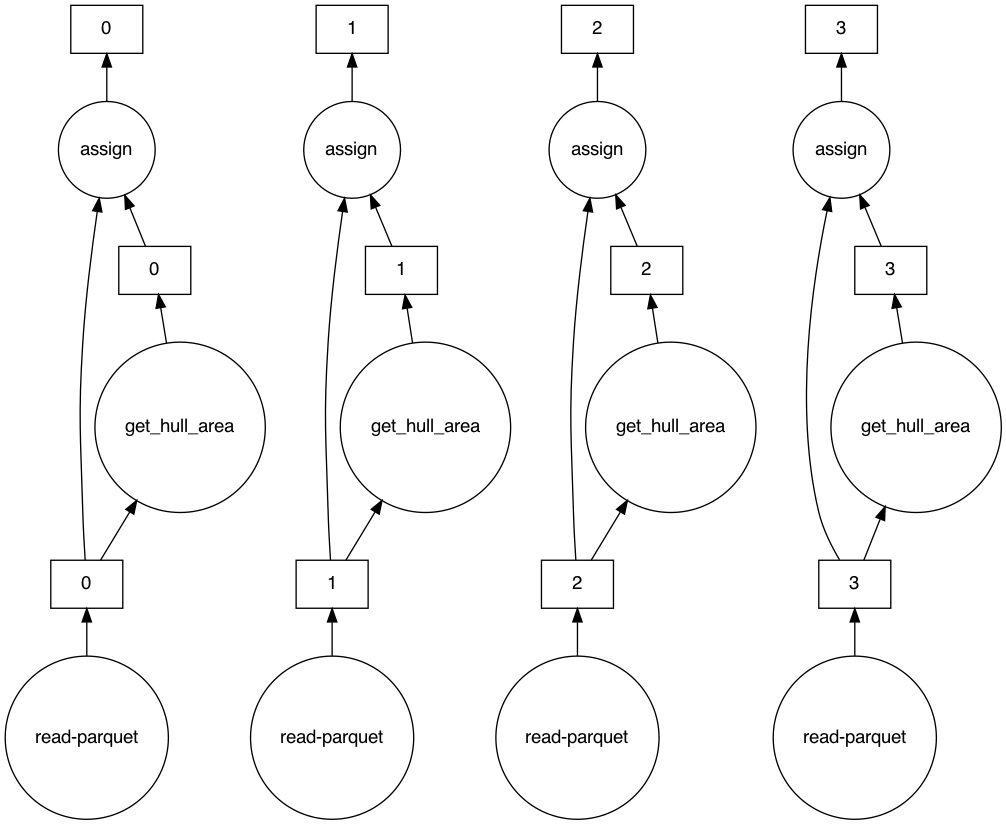

In [69]:
world_ddf.visualize()

### Speficying `meta`

In [70]:
world_ddf = dask_geopandas.read_parquet("data/world/")

In [71]:
shuffled = world_ddf.shuffle(
    "continent", npartitions=4, ignore_index=True
)

In [72]:
meta = world_ddf._meta.dissolve(by="continent", as_index=False)
meta

,continent,geometry,pop_est,name,iso_a3,gdp_md_est,convex_hull


In [73]:
meta.dtypes

continent        object
geometry       geometry
pop_est           int64
name             object
iso_a3           object
gdp_md_est      float64
convex_hull    geometry
dtype: object

In [74]:
dissolved = shuffled.map_partitions(
    geopandas.GeoDataFrame.dissolve, by="continent", as_index=False, meta=meta
)

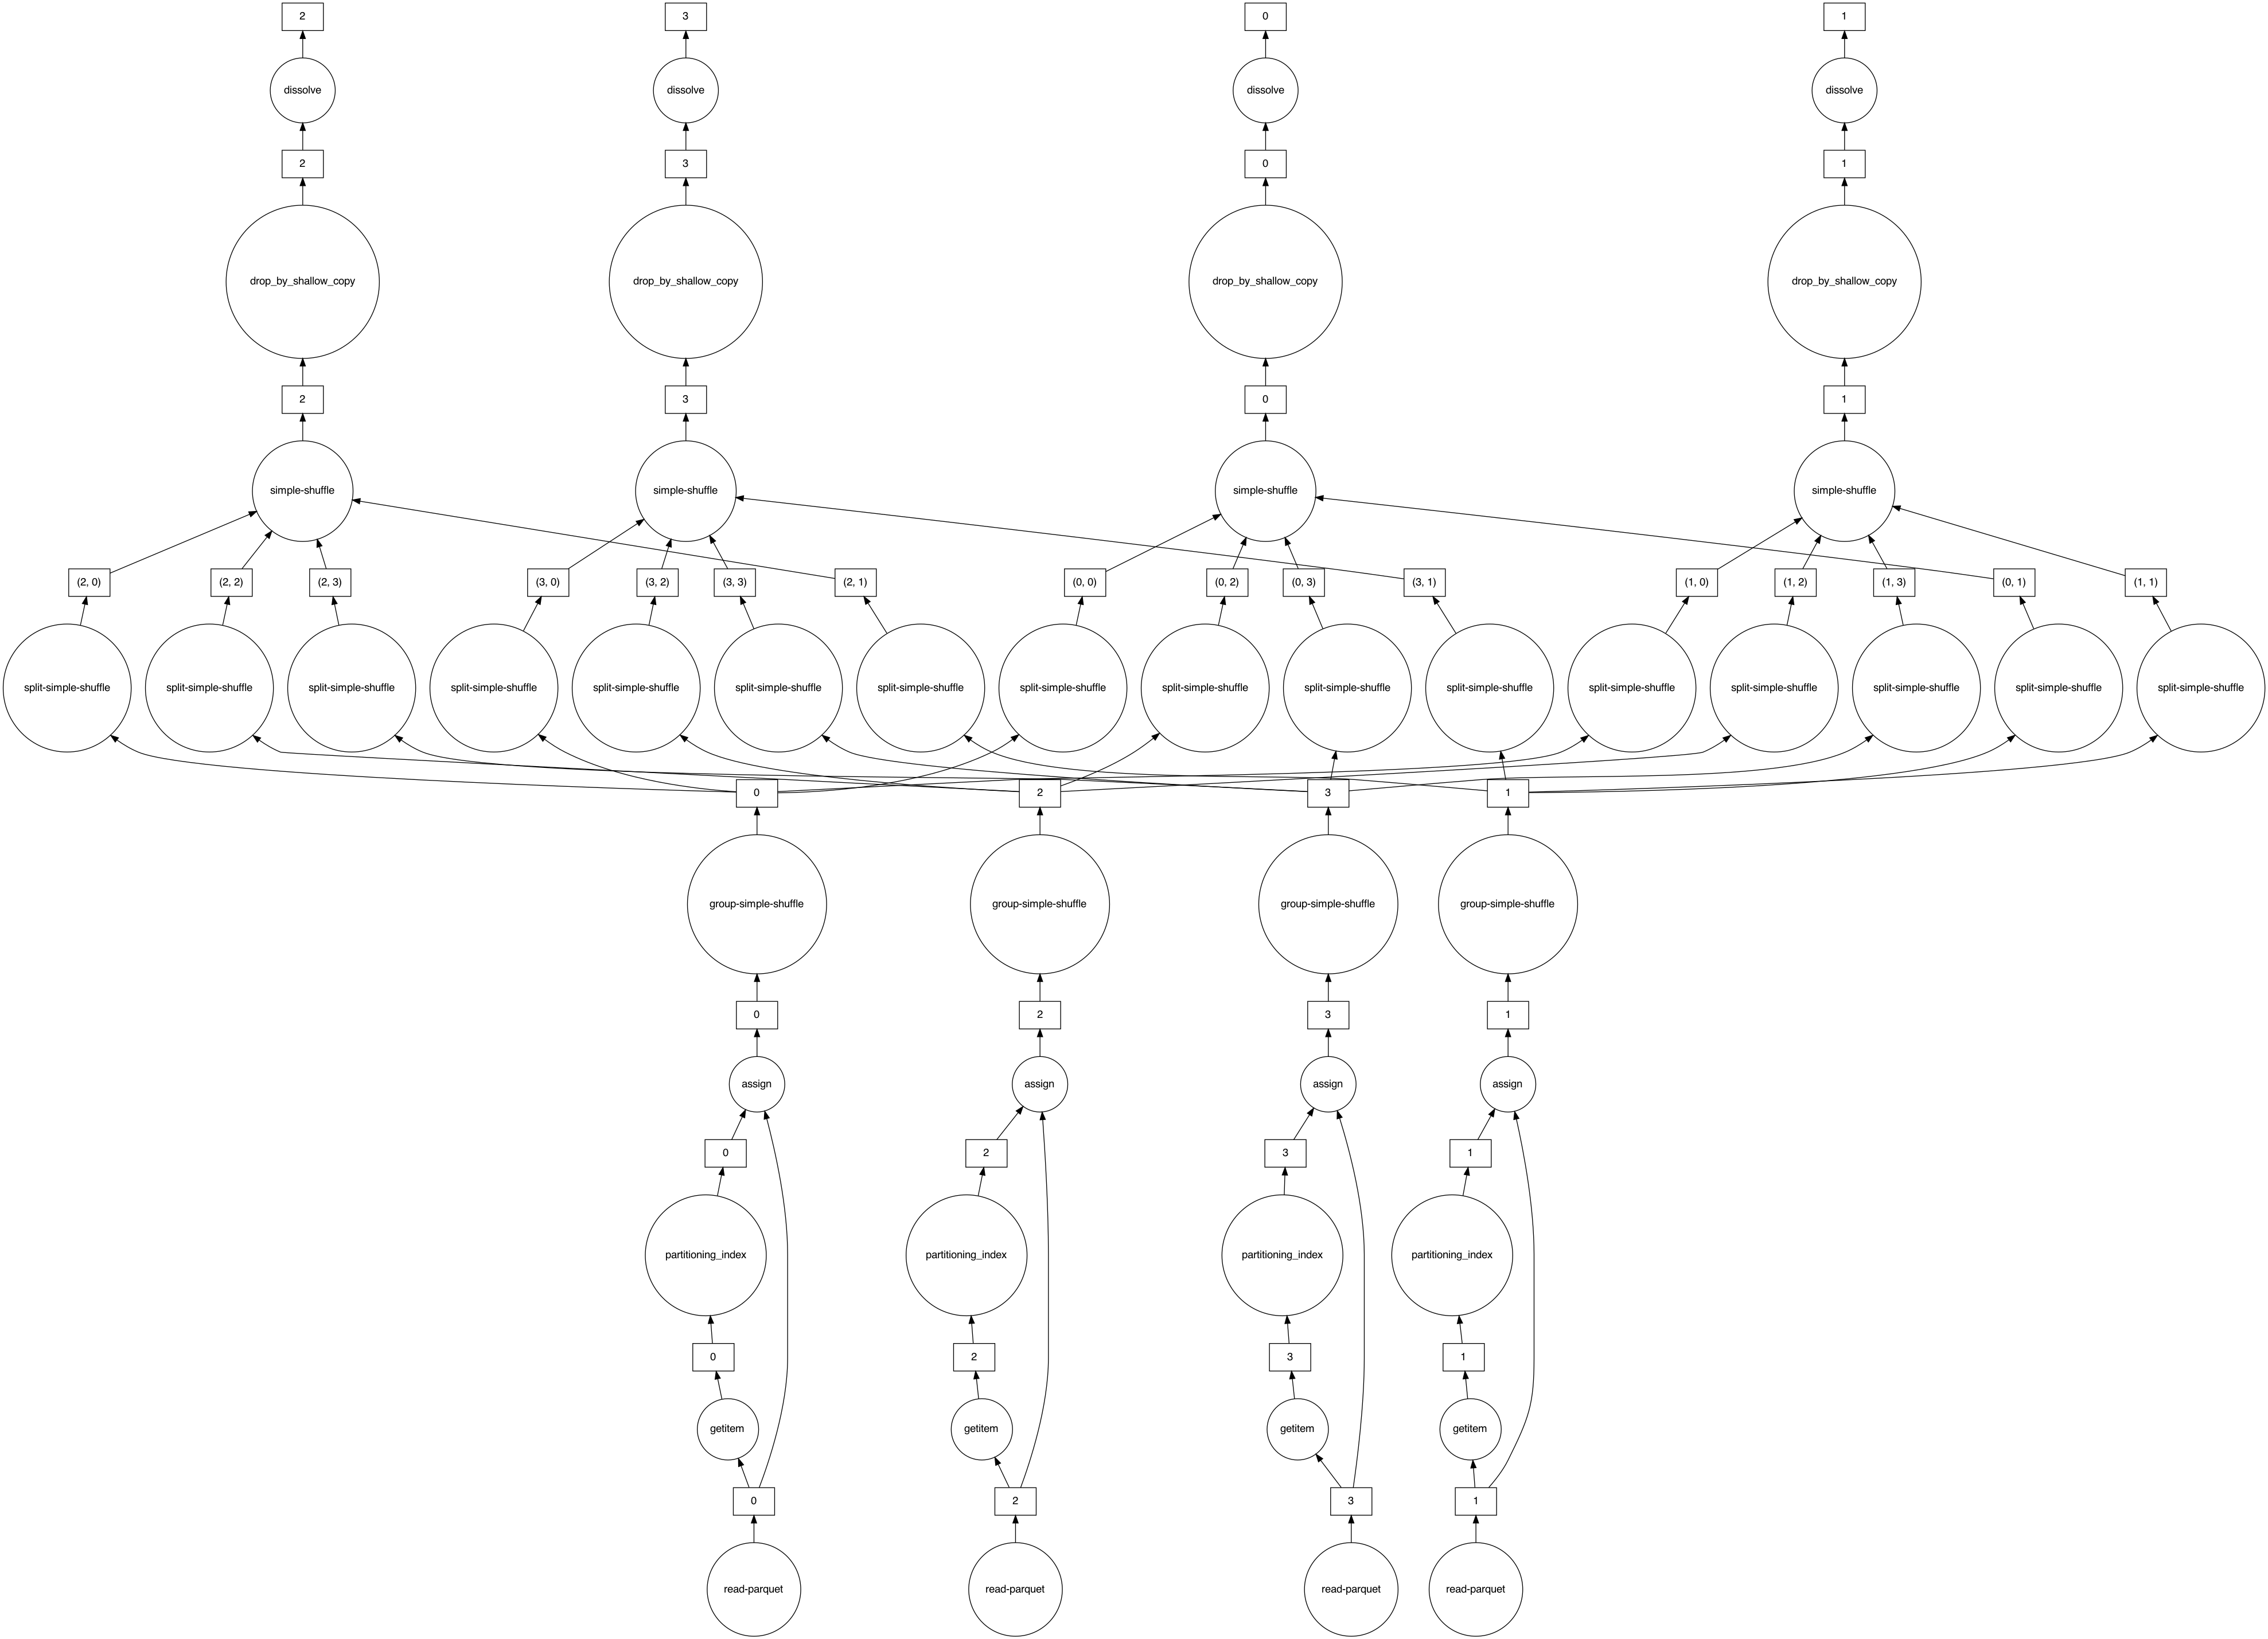

In [75]:
dissolved.visualize()

In [76]:
dissolved.compute()

,continent,geometry,pop_est,name,iso_a3,gdp_md_est,convex_hull
0,Africa,"MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6...",53950935,Tanzania,TZA,150600.0,"POLYGON ((4064728.977 -1313965.660, 3847200.38..."
0,Asia,"MULTIPOLYGON (((48.67923 14.00320, 48.23895 13...",18556698,Kazakhstan,KAZ,460700.0,"POLYGON ((7598656.850 4962661.474, 6173250.313..."
1,Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",140,Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((7652658.395 -6407400.602, 7649875.40..."
2,South America,"MULTIPOLYGON (((-68.63999 -55.58002, -69.23210...",44293293,Argentina,ARG,879400.0,"POLYGON ((-7397180.163 -7410537.977, -7640229...."
0,Oceania,"MULTIPOLYGON (((147.91405 -43.21152, 147.56456...",920938,Fiji,FJI,8374.0,"POLYGON ((19807373.107 -2071284.965, -20037508..."
0,Europe,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",142257519,Russia,RUS,3745000.0,"POLYGON ((5322815.560 5034701.226, -19357551.0..."
1,North America,"MULTIPOLYGON (((-155.22217 19.23972, -155.5421...",35623680,Canada,CAN,1674000.0,"POLYGON ((-9205018.632 5112435.324, -13805051...."


## Running dask-geopandas on a cluster
- some embarrassingly parallel things
- spatial join?

## Limits and caveats
- topology and cross-partition operations
- limited plotting support

## Exercises